===== STRATEGY PERFORMANCE =====
Initial Capital: ₹7,000,000.00
Final Capital: ₹152,992,337.09
Net Returns: ₹145,992,337.09
CAGR: 65.75%

===== TRADE STATISTICS =====
Total Trades: 1516
Winning Trades: 714
Losing Trades: 802
Win Rate: 47.10%
Trade Frequency: 20.41 trades per month

===== RISK METRICS =====
Sharpe Ratio: 3.12
Calmar Ratio: 5.54
Max Drawdown: 11.87%
Average Drawdown Duration: 8.79 days
Max Drawdown Duration: 167.00 days
Total Time in Drawdown: 1662.00 days

===== MONTHLY PERFORMANCE =====
Positive Months: 58
Negative Months: 16
Monthly Consistency: 78.38%


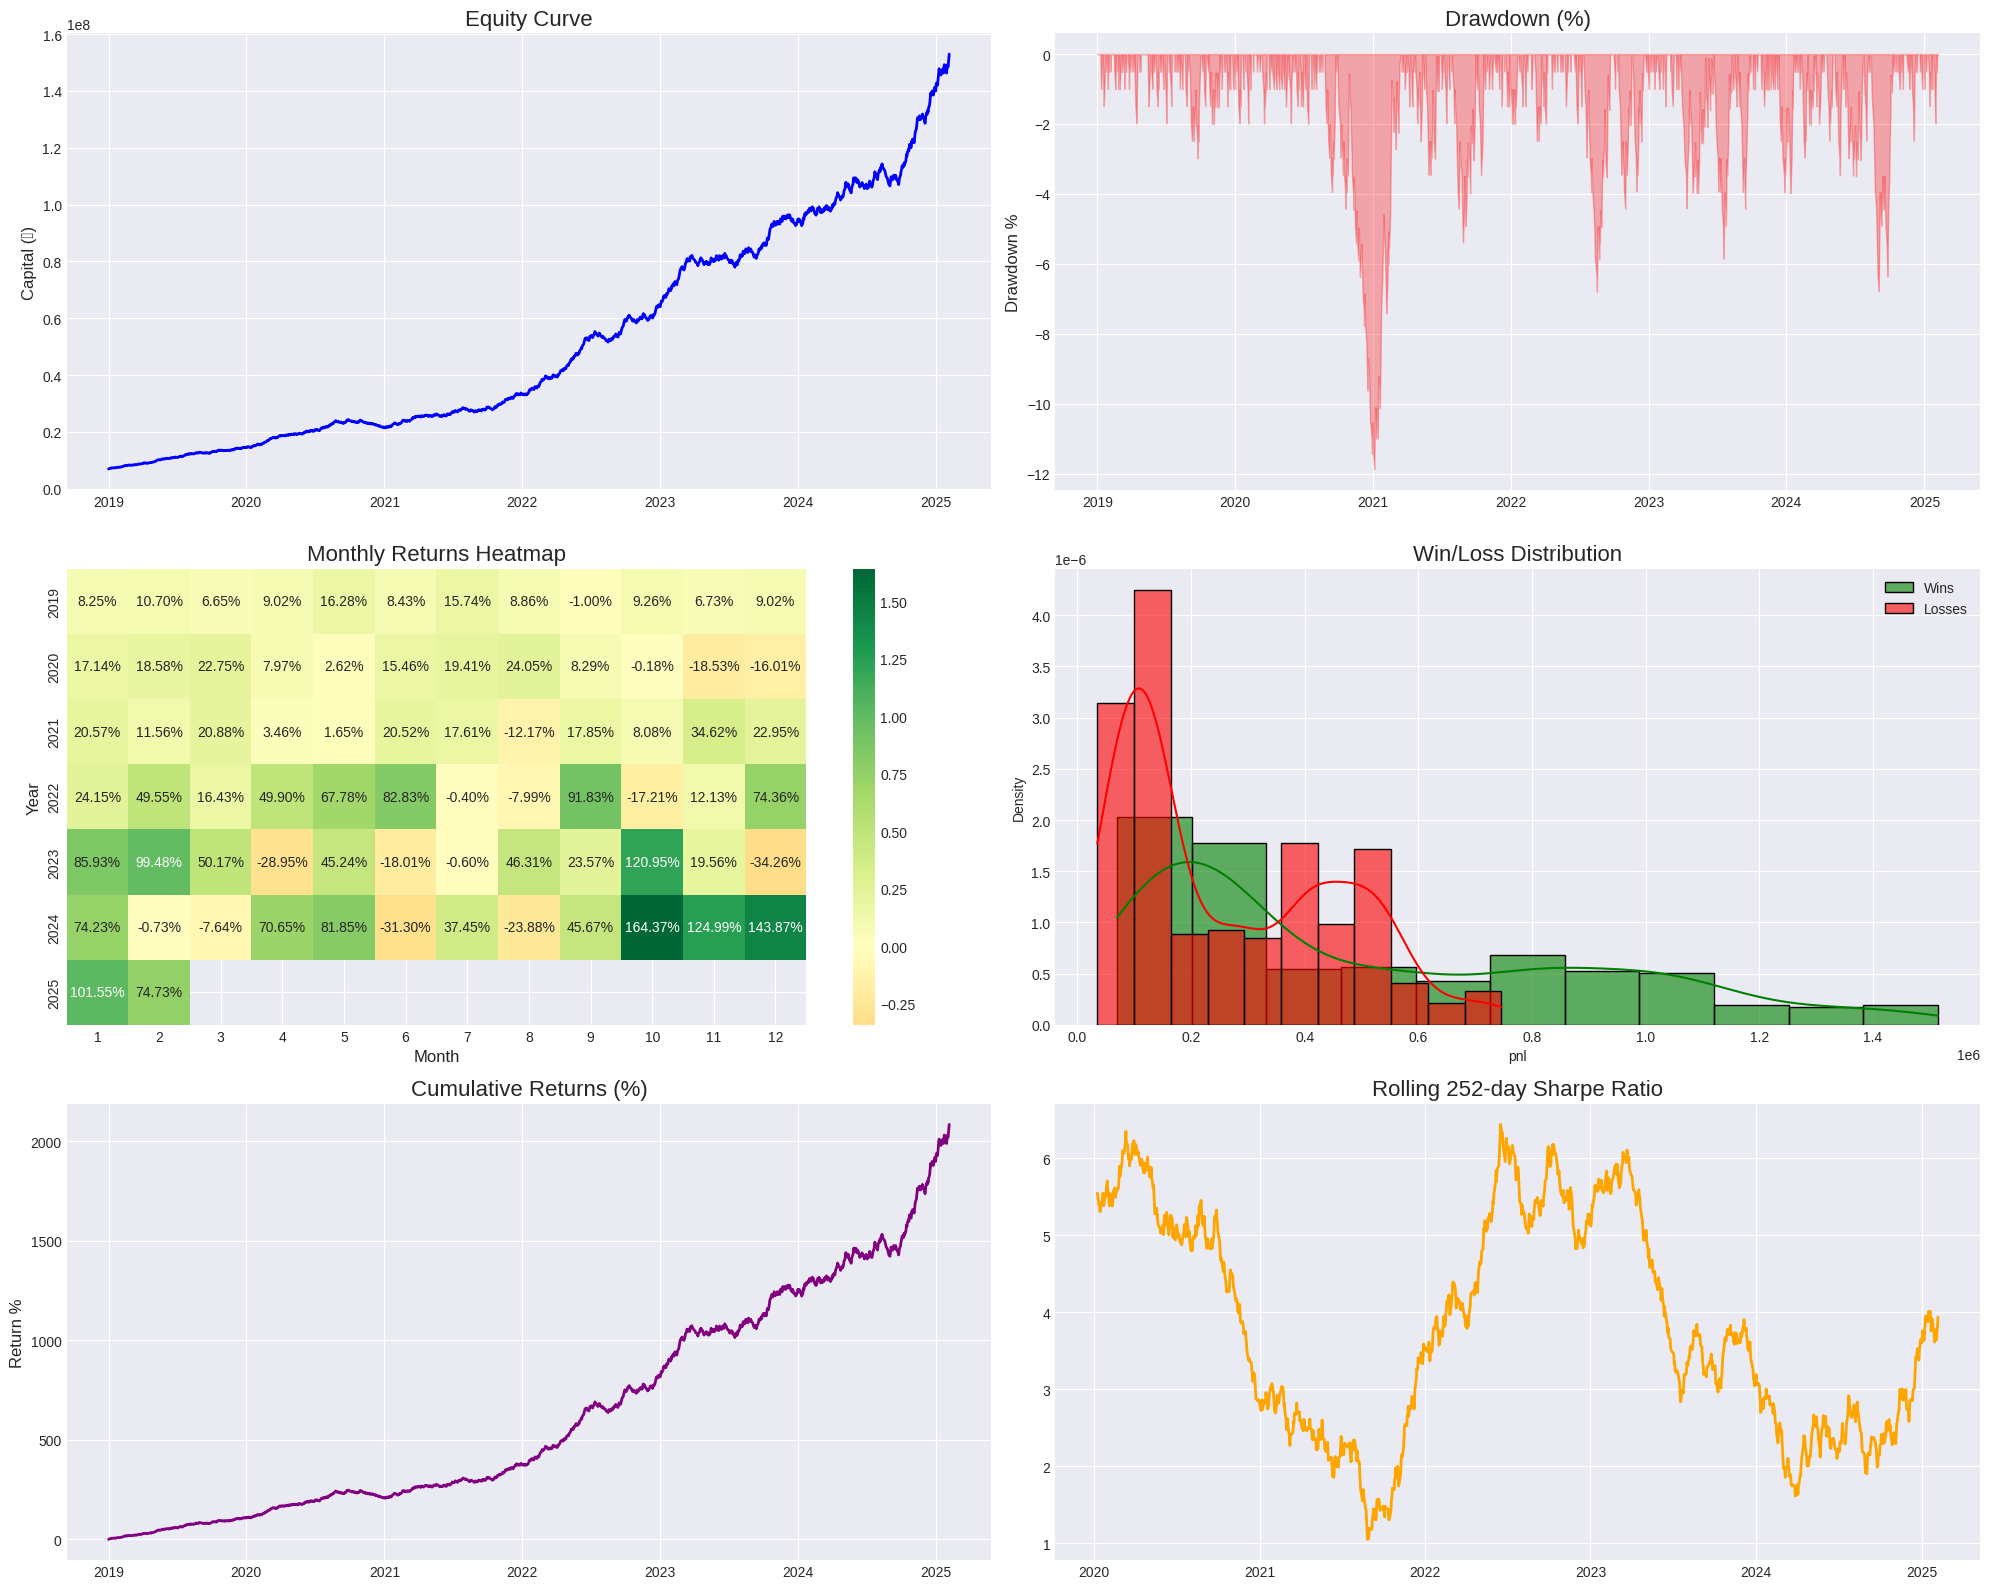


Detailed Monthly Performance:
                  pnl  correct  trades   win_rate  monthly_return
date                                                             
2019-01  5.771643e+05       13      23  56.521739        8.245205
2019-02  7.490221e+05       13      20  65.000000       10.700316
2019-03  4.654070e+05       10      19  52.631579        6.648671
2019-04  6.313667e+05       11      19  57.894737        9.019524
2019-05  1.139608e+06       15      22  68.181818       16.280115
...               ...      ...     ...        ...             ...
2024-10  1.150619e+07       14      22  63.636364      164.374192
2024-11  8.749417e+06       11      19  57.894737      124.991675
2024-12  1.007056e+07       12      21  57.142857      143.865115
2025-01  7.108429e+06       11      23  47.826087      101.548980
2025-02  5.230901e+06        4       5  80.000000       74.727159

[74 rows x 5 columns]


In [27]:
#nifty 50 daily stratergy (updated code)

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("viridis")


df = pd.read_csv("NIFTY 50_daily_data.csv", parse_dates=["date"])
df = df.sort_values("date").reset_index(drop=True)


df['SMA_5'] = df['close'].rolling(window=5).mean()
df['SMA_10'] = df['close'].rolling(window=10).mean()
df['EMA_5'] = df['close'].ewm(span=5).mean()
df['EMA_10'] = df['close'].ewm(span=10).mean()
df['Momentum'] = df['close'] - df['close'].shift(5)
df['RSI'] = 100 - (100 / (1 + df['close'].pct_change().rolling(14).mean() / df['close'].pct_change().rolling(14).std()))
df['Volatility'] = df['close'].rolling(10).std()
df['Return'] = df['close'].pct_change()


df = df.dropna().reset_index(drop=True)

df['target'] = (df['close'].shift(-1) > df['close']).astype(int)

train_data = df[df['date'] < '2019-01-01']
test_data = df[df['date'] >= '2019-01-01']

features = ['SMA_5', 'SMA_10', 'EMA_5', 'EMA_10', 'Momentum', 'RSI', 'Volatility', 'Return']

X_train = train_data[features]
y_train = train_data['target']
X_test = test_data[features]
y_test = test_data['target']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

initial_capital = 7000000  # ₹70 lakhs
capital = initial_capital
take_profit_pct = 0.10  # 10% target
stop_loss_pct = 0.05    # 5% stop loss
capital_per_trade_pct = 0.10  # 10% of capital per trade

wins = 0
losses = 0
trade_log = []


test_data = test_data.reset_index(drop=True)
X_test = pd.DataFrame(X_test, columns=features)


for i in range(len(test_data) - 1):
    today = test_data.loc[i]
    tomorrow = test_data.loc[i + 1]

    X_current = X_test.iloc[i].values.reshape(1, -1)
    prediction = model.predict(X_current)[0]

    actual_direction = int(tomorrow['close'] > today['close'])
    correct = (prediction == actual_direction)

    actual_investment = capital * capital_per_trade_pct

    if correct:
        pnl = actual_investment * take_profit_pct
        wins += 1
    else:
        pnl = -actual_investment * stop_loss_pct
        losses += 1

    capital += pnl

    trade_log.append({
        "date": today["date"],
        "prediction": prediction,
        "actual": actual_direction,
        "correct": correct,
        "pnl": pnl,
        "capital": capital
    })


trade_df = pd.DataFrame(trade_log)
trade_df['daily_return'] = trade_df['pnl'] / initial_capital
trade_df['cumulative_return'] = (trade_df['capital'] / initial_capital) - 1


def calculate_metrics(trade_df):
    metrics = {}


    metrics['initial_capital'] = initial_capital
    metrics['final_capital'] = capital
    metrics['net_returns'] = capital - initial_capital
    metrics['total_trades'] = wins + losses
    metrics['winning_trades'] = wins
    metrics['losing_trades'] = losses
    metrics['win_rate'] = (wins / (wins + losses)) * 100 if (wins + losses) > 0 else 0

    days_elapsed = (trade_df['date'].iloc[-1] - trade_df['date'].iloc[0]).days
    metrics['trade_frequency'] = len(trade_df) / days_elapsed * 30  # Average trades per month


    trade_df['high_watermark'] = trade_df['capital'].cummax()
    trade_df['drawdown'] = (trade_df['capital'] - trade_df['high_watermark']) / trade_df['high_watermark']
    metrics['max_drawdown'] = abs(trade_df['drawdown'].min()) * 100  # in percentage

    in_drawdown = False
    drawdown_start = None
    drawdown_durations = []

    for i, row in trade_df.iterrows():
        if row['drawdown'] < 0 and not in_drawdown:
            in_drawdown = True
            drawdown_start = row['date']
        elif row['drawdown'] == 0 and in_drawdown:
            in_drawdown = False
            duration = (row['date'] - drawdown_start).days
            drawdown_durations.append(duration)


    if in_drawdown:
        duration = (trade_df['date'].iloc[-1] - drawdown_start).days
        drawdown_durations.append(duration)

    metrics['avg_drawdown_duration'] = np.mean(drawdown_durations) if drawdown_durations else 0
    metrics['max_drawdown_duration'] = max(drawdown_durations) if drawdown_durations else 0
    metrics['total_drawdown_time'] = sum(drawdown_durations) if drawdown_durations else 0

    daily_returns = trade_df['daily_return'].values
    metrics['avg_daily_return'] = np.mean(daily_returns)
    metrics['std_daily_return'] = np.std(daily_returns)

    risk_free_rate = 0.04 / 252  # Daily risk-free rate
    metrics['sharpe_ratio'] = (metrics['avg_daily_return'] - risk_free_rate) / metrics['std_daily_return'] * np.sqrt(252)


    years = days_elapsed / 365
    metrics['cagr'] = ((capital / initial_capital) ** (1 / years) - 1) * 100 if years > 0 else 0


    metrics['calmar_ratio'] = metrics['cagr'] / metrics['max_drawdown'] if metrics['max_drawdown'] > 0 else np.inf


    trade_df['year_month'] = trade_df['date'].dt.strftime('%Y-%m')
    monthly_returns = trade_df.groupby('year_month')['pnl'].sum() / initial_capital
    metrics['monthly_returns'] = monthly_returns
    metrics['positive_months'] = (monthly_returns > 0).sum()
    metrics['negative_months'] = (monthly_returns < 0).sum()
    metrics['monthly_consistency'] = metrics['positive_months'] / len(monthly_returns) if len(monthly_returns) > 0 else 0

    return metrics


performance_metrics = calculate_metrics(trade_df)


print(f"===== STRATEGY PERFORMANCE =====")
print(f"Initial Capital: ₹{performance_metrics['initial_capital']:,.2f}")
print(f"Final Capital: ₹{performance_metrics['final_capital']:,.2f}")
print(f"Net Returns: ₹{performance_metrics['net_returns']:,.2f}")
print(f"CAGR: {performance_metrics['cagr']:.2f}%")
print(f"\n===== TRADE STATISTICS =====")
print(f"Total Trades: {performance_metrics['total_trades']}")
print(f"Winning Trades: {performance_metrics['winning_trades']}")
print(f"Losing Trades: {performance_metrics['losing_trades']}")
print(f"Win Rate: {performance_metrics['win_rate']:.2f}%")
print(f"Trade Frequency: {performance_metrics['trade_frequency']:.2f} trades per month")
print(f"\n===== RISK METRICS =====")
print(f"Sharpe Ratio: {performance_metrics['sharpe_ratio']:.2f}")
print(f"Calmar Ratio: {performance_metrics['calmar_ratio']:.2f}")
print(f"Max Drawdown: {performance_metrics['max_drawdown']:.2f}%")
print(f"Average Drawdown Duration: {performance_metrics['avg_drawdown_duration']:.2f} days")
print(f"Max Drawdown Duration: {performance_metrics['max_drawdown_duration']:.2f} days")
print(f"Total Time in Drawdown: {performance_metrics['total_drawdown_time']:.2f} days")
print(f"\n===== MONTHLY PERFORMANCE =====")
print(f"Positive Months: {performance_metrics['positive_months']}")
print(f"Negative Months: {performance_metrics['negative_months']}")
print(f"Monthly Consistency: {performance_metrics['monthly_consistency']*100:.2f}%")

def create_visualizations(trade_df, performance_metrics):
    fig = plt.figure(figsize=(20, 16))


    ax1 = plt.subplot(3, 2, 1)
    ax1.plot(trade_df['date'], trade_df['capital'], linewidth=2, color='blue')
    ax1.set_title('Equity Curve', fontsize=16)
    ax1.set_ylabel('Capital (₹)', fontsize=12)
    ax1.grid(True)

    ax2 = plt.subplot(3, 2, 2)
    ax2.fill_between(trade_df['date'], trade_df['drawdown'] * 100, 0, color='red', alpha=0.3)
    ax2.set_title('Drawdown (%)', fontsize=16)
    ax2.set_ylabel('Drawdown %', fontsize=12)
    ax2.grid(True)

    ax3 = plt.subplot(3, 2, 3)

    monthly_data = trade_df.copy()
    monthly_data['year'] = monthly_data['date'].dt.year
    monthly_data['month'] = monthly_data['date'].dt.month

    monthly_returns = monthly_data.groupby(['year', 'month'])['pnl'].sum() / initial_capital
    monthly_returns = monthly_returns.reset_index()

    if not monthly_returns.empty:
        pivot_table = monthly_returns.pivot(index='year', columns='month', values='pnl')
        sns.heatmap(pivot_table, cmap='RdYlGn', annot=True, fmt='.2%', ax=ax3, center=0)
        ax3.set_title('Monthly Returns Heatmap', fontsize=16)
        ax3.set_xlabel('Month', fontsize=12)
        ax3.set_ylabel('Year', fontsize=12)
    else:
        ax3.text(0.5, 0.5, 'Insufficient data for monthly heatmap',
                 horizontalalignment='center', verticalalignment='center')

    ax4 = plt.subplot(3, 2, 4)
    wins_data = trade_df[trade_df['pnl'] > 0]['pnl']
    losses_data = abs(trade_df[trade_df['pnl'] < 0]['pnl'])

    if len(wins_data) > 0:
        sns.histplot(wins_data, color='green', label='Wins', kde=True, stat='density', alpha=0.6, ax=ax4)
    if len(losses_data) > 0:
        sns.histplot(losses_data, color='red', label='Losses', kde=True, stat='density', alpha=0.6, ax=ax4)

    ax4.set_title('Win/Loss Distribution', fontsize=16)
    ax4.legend()

    ax5 = plt.subplot(3, 2, 5)
    ax5.plot(trade_df['date'], trade_df['cumulative_return'] * 100, linewidth=2, color='purple')
    ax5.set_title('Cumulative Returns (%)', fontsize=16)
    ax5.set_ylabel('Return %', fontsize=12)
    ax5.grid(True)

    ax6 = plt.subplot(3, 2, 6)
    returns = trade_df['daily_return'].values
    rolling_sharpe = []
    window = min(252, len(returns) - 1)

    if window > 0:
        for i in range(window, len(returns) + 1):
            window_returns = returns[i - window:i]
            sharpe = (np.mean(window_returns) - 0.04/252) / (np.std(window_returns) + 1e-10) * np.sqrt(252)
            rolling_sharpe.append(sharpe)

        if rolling_sharpe:
            dates = trade_df['date'].iloc[window-1:].values
            ax6.plot(dates, rolling_sharpe, linewidth=2, color='orange')
            ax6.set_title('Rolling 252-day Sharpe Ratio', fontsize=16)
            ax6.grid(True)
    else:
        ax6.text(0.5, 0.5, 'Insufficient data for rolling Sharpe ratio',
                 horizontalalignment='center', verticalalignment='center')

    plt.tight_layout()
    return fig

fig = create_visualizations(trade_df, performance_metrics)
plt.savefig('nifty_strategy_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nDetailed Monthly Performance:")
monthly_performance = trade_df.groupby(trade_df['date'].dt.strftime('%Y-%m')).agg({
    'pnl': 'sum',
    'correct': 'sum',
    'date': 'count'
}).rename(columns={'date': 'trades'})

monthly_performance['win_rate'] = monthly_performance['correct'] / monthly_performance['trades'] * 100
monthly_performance['monthly_return'] = monthly_performance['pnl'] / initial_capital * 100
print(monthly_performance.sort_index())

In [28]:
#15 min
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from datetime import datetime

def read_price_data(path):
    df = pd.read_csv(path)
    df['datetime'] = pd.to_datetime(df['date'], format='mixed')
    df.drop_duplicates(inplace=True)
    df.dropna(subset=['close', 'datetime'], inplace=True)
    df.set_index('datetime', inplace=True)
    df = df.resample('15min').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last'}).dropna()
    # df = df[(df.index >= '2024-01-01')]
    df = df.reset_index()
    return df

def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=period).mean()
    avg_loss = pd.Series(loss).rolling(window=period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def rsi_momentum_strategy(df, rsi_period=14, momentum_period=45):
    df['rsi'] = calculate_rsi(df['close'], rsi_period)
    df['momentum'] = df['close'].diff(momentum_period)
    df['future_return'] = df['close'].shift(-5) / df['close'] - 1
    df['target'] = (df['future_return'] > 0).astype(int)

    features = df[['rsi', 'momentum']].dropna()
    labels = df['target'].loc[features.index]

    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle=False)
    model = RandomForestClassifier(n_estimators=100)
    model.fit(X_train, y_train)

    df['signal'] = 0
    pred_idx = df[['rsi', 'momentum']].dropna().index
    df.loc[pred_idx, 'signal'] = model.predict(df.loc[pred_idx, ['rsi', 'momentum']])

    return df

def execute_trades(df, capital=1_000_000, position_fraction=0.25, stop_loss_pct=0.85, take_profit_pct=1.10):
    df['date_only'] = df['datetime'].dt.date
    df['portfolio_value'] = capital
    df['equity_curve'] = capital
    df['returns'] = 0.0
    df['drawdown'] = 0.0
    df['trade'] = 0
    df['profit'] = 0.0

    trades = []
    trade_dates = []
    daily_trades = {}
    equity_curve = [capital]
    returns = []

    signals = df[df['signal'] == 1]
    for row in signals.itertuples():
        date = row.date_only
        if daily_trades.get(date, 0) < 3:
            price = row.close
            allocated_capital = capital * position_fraction
            shares = allocated_capital / price
            stop_loss = price * stop_loss_pct # e.g., 15% stop
            take_profit = price * take_profit_pct # 10% profit

            # Simulate next 5 candles to determine exit
            future_prices = df.loc[row.Index:row.Index+5, 'close'].values if row.Index+5 < len(df) else df.loc[row.Index:, 'close'].values
            exit_price = price
            exit_index = row.Index

            for i, p in enumerate(future_prices):
                if p <= stop_loss:
                    exit_price = stop_loss
                    exit_index = row.Index + i
                    break
                if p >= take_profit:
                    exit_price = take_profit
                    exit_index = row.Index + i
                    break
                if i == len(future_prices) - 1:
                    exit_price = p # fallback to last price
                    exit_index = row.Index + i

            profit = (exit_price - price) * shares
            capital += profit


            df.at[row.Index, 'trade'] = 1
            df.at[row.Index, 'profit'] = profit


            df.at[exit_index, 'portfolio_value'] = capital
            df.at[exit_index, 'equity_curve'] = capital

            trades.append(profit)
            trade_dates.append(row.datetime)
            daily_trades[date] = daily_trades.get(date, 0) + 1

            equity_curve.append(capital)
            returns.append(profit / allocated_capital)


    last_value = capital
    for i in range(len(df)):
        if df.at[i, 'equity_curve'] == 0:
            df.at[i, 'equity_curve'] = last_value
        else:
            last_value = df.at[i, 'equity_curve']

    df['returns'] = df['equity_curve'].pct_change().fillna(0)
    df['cumulative_returns'] = (1 + df['returns']).cumprod()

    df['peak'] = df['equity_curve'].cummax()
    df['drawdown'] = (df['equity_curve'] - df['peak']) / df['peak']

    total_profit = capital - 1_000_000
    win_count = sum(1 for trade in trades if trade > 0)
    win_rate = win_count / len(trades) if trades else 0


    print(f"📈 Final Capital: ₹{capital:,.2f} | Profit: ₹{total_profit:,.2f} ({(total_profit / 1_000_000) * 100:.2f}%)")
    print(f"Win rate: {win_rate * 100:.2f}%")

    return df, trades, trade_dates

def calculate_performance_metrics(df, trades, trade_dates, initial_capital=1_000_000):
    """Calculate advanced performance metrics"""
    equity_curve = df['equity_curve'].values


    returns = np.diff(equity_curve) / equity_curve[:-1]


    max_drawdown = df['drawdown'].min()
    max_drawdown_pct = max_drawdown * 100

    df['is_drawdown'] = df['drawdown'] < 0
    drawdown_periods = df['is_drawdown'].sum()
    total_periods = len(df)
    time_in_drawdown = drawdown_periods / total_periods

    current_drawdown = 0
    longest_drawdown = 0
    for is_down in df['is_drawdown']:
        if is_down:
            current_drawdown += 1
        else:
            current_drawdown = 0
        longest_drawdown = max(longest_drawdown, current_drawdown)


    df['date_only'] = pd.to_datetime(df['datetime']).dt.date
    daily_returns = df.groupby('date_only')['equity_curve'].last().pct_change().dropna()


    sharpe_ratio = daily_returns.mean() / daily_returns.std() * np.sqrt(252) if daily_returns.std() > 0 else 0

    days = (df['datetime'].iloc[-1] - df['datetime'].iloc[0]).days
    if days > 0:
        total_return = (equity_curve[-1] / initial_capital) - 1
        annualized_return = (1 + total_return) ** (365 / days) - 1
        calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else float('inf')
    else:
        annualized_return = 0
        calmar_ratio = 0


    if days > 0:
        cagr = (equity_curve[-1] / initial_capital) ** (365 / days) - 1
    else:
        cagr = 0

    if days > 0:
        trade_frequency = len(trades) / (days / 365)  # Trades per year
    else:
        trade_frequency = 0

    df['month'] = pd.to_datetime(df['datetime']).dt.to_period('M')
    monthly_returns = df.groupby('month')['equity_curve'].last().pct_change().dropna()
    month_on_month_consistency = (monthly_returns > 0).mean()

    print("\n--- PERFORMANCE METRICS ---")
    print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
    print(f"Calmar Ratio: {calmar_ratio:.4f}")
    print(f"Max Drawdown: {max_drawdown_pct:.2f}%")
    print(f"Time in Drawdown: {time_in_drawdown*100:.2f}% of time")
    print(f"Longest Drawdown Duration: {longest_drawdown} periods")
    print(f"CAGR: {cagr*100:.2f}%")
    print(f"Trade Frequency: {trade_frequency:.2f} trades per year")
    print(f"Month-on-Month Performance Consistency: {month_on_month_consistency*100:.2f}%")

    metrics = {
        'sharpe_ratio': sharpe_ratio,
        'calmar_ratio': calmar_ratio,
        'max_drawdown': max_drawdown,
        'time_in_drawdown': time_in_drawdown,
        'longest_drawdown': longest_drawdown,
        'cagr': cagr,
        'trade_frequency': trade_frequency,
        'month_on_month_consistency': month_on_month_consistency,
        'monthly_returns': monthly_returns
    }

    return metrics

def plot_performance(df, trades, trade_dates, metrics):
    """Create performance visualizations"""
    plt.figure(figsize=(16, 20))


    plt.subplot(4, 1, 1)
    plt.plot(df['datetime'], df['equity_curve'])
    plt.title('Equity Curve')
    plt.grid(True)


    for date, trade in zip(trade_dates, trades):
        if trade > 0:
            plt.scatter(date, df.loc[df['datetime'] == date, 'equity_curve'].values[0],
                       color='green', marker='^', s=50)
        else:
            plt.scatter(date, df.loc[df['datetime'] == date, 'equity_curve'].values[0],
                       color='red', marker='v', s=50)


    plt.subplot(4, 1, 2)
    plt.fill_between(df['datetime'], df['drawdown'] * 100, 0, color='red', alpha=0.3)
    plt.title('Drawdown (%)')
    plt.grid(True)


    monthly_returns = metrics['monthly_returns']
    plt.subplot(4, 1, 3)
    monthly_returns.plot(kind='bar', color=monthly_returns.map(lambda x: 'green' if x > 0 else 'red'))
    plt.title('Monthly Returns')
    plt.grid(True)


    plt.subplot(4, 1, 4)
    plt.hist(trades, bins=20, alpha=0.7)
    plt.axvline(x=0, color='black', linestyle='--')
    plt.title('Trade Profit/Loss Distribution')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('strategy_performance.png')
    plt.close()

    print("\nPerformance charts generated and saved as 'strategy_performance.png'")

def run_strategy(file_path):
    """Execute the trading strategy and calculate performance metrics"""
    print(f"Loading data from {file_path}...")
    df = read_price_data(file_path)
    print(f"Data loaded: {len(df)} rows")

    print("Running RSI-Momentum strategy...")
    df = rsi_momentum_strategy(df)

    print("Executing trades...")
    df, trades, trade_dates = execute_trades(df)

    print("Calculating performance metrics...")
    metrics = calculate_performance_metrics(df, trades, trade_dates)

    print("Generating performance charts...")
    plot_performance(df, trades, trade_dates, metrics)

    return df, metrics

if __name__ == "__main__":
    run_strategy("NIFTY 50_minute_data.csv")

Loading data from NIFTY 50_minute_data.csv...
Data loaded: 62207 rows
Running RSI-Momentum strategy...
Executing trades...
📈 Final Capital: ₹15,439,415.89 | Profit: ₹14,439,415.89 (1443.94%)
Win rate: 90.32%
Calculating performance metrics...

--- PERFORMANCE METRICS ---
Sharpe Ratio: 1.3157
Calmar Ratio: 0.0000
Max Drawdown: -93.71%
Time in Drawdown: 90.38% of time
Longest Drawdown Duration: 10116 periods
CAGR: 0.00%
Trade Frequency: 736.44 trades per year
Month-on-Month Performance Consistency: 0.83%
Generating performance charts...

Performance charts generated and saved as 'strategy_performance.png'


In [29]:
#60 minute strategy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from datetime import datetime

def read_price_data(path):
    df = pd.read_csv(path)
    df['datetime'] = pd.to_datetime(df['date'], format='mixed')
    df.drop_duplicates(inplace=True)
    df.dropna(subset=['close', 'datetime'], inplace=True)
    df.set_index('datetime', inplace=True)
    df = df.resample('1H').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last'}).dropna()
    df = df[df.index >= '2019-01-01']
    df.reset_index(inplace=True)
    return df

def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=period).mean()
    avg_loss = pd.Series(loss).rolling(window=period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def calculate_bollinger_bands(series, period=20):
    middle_band = series.rolling(window=period).mean()
    std = series.rolling(window=period).std()
    upper_band = middle_band + (2 * std)
    lower_band = middle_band - (2 * std)
    return upper_band, middle_band, lower_band

def add_indicators(df):
    df['sma_fast'] = df['close'].rolling(window=5).mean()
    df['sma_slow'] = df['close'].rolling(window=20).mean()
    df['rsi'] = calculate_rsi(df['close'])
    df['bb_upper'], df['bb_middle'], df['bb_lower'] = calculate_bollinger_bands(df['close'])
    df['mean_reversion'] = df['close'] - df['close'].rolling(window=20).mean()
    df.dropna(inplace=True)
    return df

def generate_targets(df):
    df['future_return'] = df['close'].shift(-2) / df['close'] - 1
    df['target'] = (df['future_return'] > 0).astype(int)
    return df

def train_model(df):
    features = ['sma_fast', 'sma_slow', 'rsi', 'bb_upper', 'bb_middle', 'bb_lower', 'mean_reversion']
    df = df.dropna()
    X = df[features]
    y = df['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    df['signal'] = 0
    df.loc[X_test.index, 'signal'] = model.predict(X_test)
    return df, model

def execute_trades(df, capital=20_00_000, risk_fraction=0.25):
    df['date_only'] = pd.to_datetime(df['datetime']).dt.date
    df['portfolio_value'] = capital
    trades = []
    trade_details = []
    daily_trades = {}

    # For metrics tracking
    initial_capital = capital
    daily_portfolio_values = {}

    for i, row in df[df['signal'] == 1].iterrows():
        date = row['date_only']
        if daily_trades.get(date, 0) >= 3:
            continue

        entry_price = row['close']
        position_size = capital * risk_fraction
        stop_loss = entry_price * 0.95
        take_profit = entry_price * 1.10
        quantity = position_size / entry_price
        exit_price = entry_price
        entry_time = row['datetime']
        exit_time = entry_time

        future_idx = i + 1
        for j in range(3):
            if future_idx + j >= len(df):
                break
            future_row = df.iloc[future_idx + j]
            future_price = future_row['close']
            if future_price <= stop_loss:
                exit_price = stop_loss
                exit_time = future_row['datetime']
                break
            elif future_price >= take_profit:
                exit_price = take_profit
                exit_time = future_row['datetime']
                break
            else:
                exit_price = future_price
                exit_time = future_row['datetime']

        profit = (exit_price - entry_price) * quantity
        capital += profit
        df.at[i, 'portfolio_value'] = capital


        trade_detail = {
            'entry_date': entry_time,
            'exit_date': exit_time,
            'entry_price': entry_price,
            'exit_price': exit_price,
            'quantity': quantity,
            'profit': profit,
            'portfolio_value': capital
        }
        trades.append(profit)
        trade_details.append(trade_detail)

        daily_trades[date] = daily_trades.get(date, 0) + 1


        daily_portfolio_values[date] = capital


    all_dates = sorted(set(df['date_only']))
    complete_daily_values = {}
    current_value = initial_capital

    for date in all_dates:
        if date in daily_portfolio_values:
            current_value = daily_portfolio_values[date]
        complete_daily_values[date] = current_value


    daily_equity = pd.DataFrame.from_dict(complete_daily_values, orient='index', columns=['portfolio_value'])
    daily_equity.index.name = 'date'

    df['portfolio_value'].fillna(method='ffill', inplace=True)
    df['portfolio_value'].fillna(initial_capital, inplace=True)


    trades_df = pd.DataFrame(trade_details)

    return df, trades_df, daily_equity

def calculate_metrics(df, trades_df, daily_equity, initial_capital=20_00_000):

    total_profit = daily_equity['portfolio_value'].iloc[-1] - initial_capital
    total_trades = len(trades_df) if not trades_df.empty else 0
    win_count = sum(1 for trade in trades_df['profit'] if trade > 0) if not trades_df.empty else 0
    win_rate = win_count / total_trades if total_trades > 0 else 0

    daily_equity['daily_return'] = daily_equity['portfolio_value'].pct_change()
    daily_equity['daily_return'].fillna(0, inplace=True)


    daily_equity.index = pd.to_datetime(daily_equity.index)

    monthly_returns = daily_equity['portfolio_value'].resample('M').last().pct_change()
    monthly_returns.fillna(0, inplace=True)


    start_date = daily_equity.index[0]
    end_date = daily_equity.index[-1]
    years = (end_date - start_date).days / 365.25
    cagr = (daily_equity['portfolio_value'].iloc[-1] / initial_capital) ** (1 / years) - 1 if years > 0 else 0


    risk_free_rate = 0.04
    daily_excess_return = daily_equity['daily_return'] - risk_free_rate/252  # Daily risk-free rate
    sharpe_ratio = (daily_excess_return.mean() * 252) / (daily_excess_return.std() * np.sqrt(252)) if daily_excess_return.std() != 0 else 0


    daily_equity['cummax'] = daily_equity['portfolio_value'].cummax()
    daily_equity['drawdown'] = (daily_equity['portfolio_value'] / daily_equity['cummax']) - 1
    max_drawdown = daily_equity['drawdown'].min()


    calmar_ratio = abs(cagr / max_drawdown) if max_drawdown != 0 else float('inf')


    in_drawdown = False
    drawdown_days = 0
    total_drawdown_days = 0

    for i in range(len(daily_equity)):
        if daily_equity['drawdown'].iloc[i] < 0:
            if not in_drawdown:
                in_drawdown = True
            drawdown_days += 1
        else:
            if in_drawdown:
                total_drawdown_days += drawdown_days
                drawdown_days = 0
                in_drawdown = False


    if in_drawdown:
        total_drawdown_days += drawdown_days

    drawdown_percentage = total_drawdown_days / len(daily_equity) if len(daily_equity) > 0 else 0

    if not trades_df.empty:
        trades_df['entry_date'] = pd.to_datetime(trades_df['entry_date'])
        total_weeks = (trades_df['entry_date'].max() - trades_df['entry_date'].min()).days / 7
        trade_frequency = total_trades / total_weeks if total_weeks > 0 else 0
    else:
        trade_frequency = 0
    monthly_consistency = monthly_returns.std()

    metrics = {
        'Total Profit': f"₹{total_profit:,.2f} ({(total_profit / initial_capital) * 100:.2f}%)",
        'CAGR': f"{cagr * 100:.2f}%",
        'Sharpe Ratio': f"{sharpe_ratio:.2f}",
        'Calmar Ratio': f"{calmar_ratio:.2f}",
        'Max Drawdown': f"{max_drawdown * 100:.2f}%",
        'Time in Drawdown': f"{drawdown_percentage * 100:.2f}% ({total_drawdown_days} days)",
        'Win Rate': f"{win_rate * 100:.2f}%",
        'Total Trades': total_trades,
        'Trade Frequency': f"{trade_frequency:.2f} trades/week",
        'Monthly Consistency (StdDev)': f"{monthly_consistency * 100:.2f}%"
    }

    return metrics, daily_equity

def plot_equity_curves(df, daily_equity, trades_df, strategy_name="NIFTY Bank Strategy"):

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 18))


    ax1.plot(df['datetime'], df['portfolio_value'], label='Portfolio Value', color='blue')
    ax1.set_title(f'Detailed Equity Curve - {strategy_name}')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Portfolio Value (₹)')
    ax1.grid(True)
    ax1.legend()


    ax2.plot(daily_equity.index, daily_equity['portfolio_value'], label='Daily Portfolio Value', color='green')
    ax2.set_title(f'Daily Equity Curve - {strategy_name}')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Portfolio Value (₹)')
    ax2.grid(True)
    ax2.legend()


    monthly_returns = daily_equity['portfolio_value'].resample('M').last().pct_change() * 100
    monthly_returns = monthly_returns.fillna(0)

    bars = ax3.bar(monthly_returns.index, monthly_returns, color=monthly_returns.apply(lambda x: 'green' if x >= 0 else 'red'))
    ax3.set_title(f'Monthly Returns - {strategy_name}')
    ax3.set_xlabel('Month')
    ax3.set_ylabel('Return (%)')
    ax3.grid(True, axis='y')

    for bar in bars:
        height = bar.get_height()
        value_text = f"{height:.1f}%" if height != 0 else "0%"
        text_position = height + 0.5 if height >= 0 else height - 1.5
        ax3.text(bar.get_x() + bar.get_width()/2., text_position, value_text, ha='center', va='bottom', rotation=0)

    plt.tight_layout()
    plt.savefig(f"{strategy_name.replace(' ', '_')}_equity_curves.png")
    plt.close()

def plot_combined_equity_curve(strategy_results, initial_capital=20_00_000):

    plt.figure(figsize=(14, 8))


    for name, daily_equity in strategy_results.items():
        plt.plot(daily_equity.index, daily_equity['portfolio_value'], label=name)

    plt.axhline(y=initial_capital, color='r', linestyle='--', label='Initial Capital')

    plt.title('Combined Equity Curves for All Strategies')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value (₹)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig("Combined_Equity_Curves.png")
    plt.close()

def run_strategy(file_path, strategy_name="NIFTY Bank Strategy"):
    print(f"\n===== Running {strategy_name} =====")
    df = read_price_data(file_path)
    df = add_indicators(df)
    df = generate_targets(df)
    df, model = train_model(df)
    df, trades_df, daily_equity = execute_trades(df)

    metrics, daily_equity = calculate_metrics(df, trades_df, daily_equity)

    print("\n=== Performance Metrics ===")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")


    plot_equity_curves(df, daily_equity, trades_df, strategy_name)

    return daily_equity



def plot_drawdown_chart(daily_equity, strategy_name="NIFTY Bank Strategy"):

    plt.figure(figsize=(14, 6))

    daily_equity['cummax'] = daily_equity['portfolio_value'].cummax()
    daily_equity['drawdown'] = (daily_equity['portfolio_value'] / daily_equity['cummax'] - 1) * 100


    plt.fill_between(daily_equity.index, daily_equity['drawdown'], 0, color='red', alpha=0.3)
    plt.plot(daily_equity.index, daily_equity['drawdown'], color='red', linewidth=1)

    plt.axhline(y=0, color='black', linestyle='-', linewidth=1)

    max_dd_date = daily_equity.loc[daily_equity['drawdown'].idxmin()].name
    max_dd_value = daily_equity['drawdown'].min()
    plt.scatter(max_dd_date, max_dd_value, color='darkred', s=100)
    plt.annotate(f'Max DD: {max_dd_value:.2f}%',
                 xy=(max_dd_date, max_dd_value),
                 xytext=(max_dd_date, max_dd_value - 5),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.title(f'Drawdown Analysis - {strategy_name}')
    plt.xlabel('Date')
    plt.ylabel('Drawdown (%)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{strategy_name.replace(' ', '_')}_drawdown.png")
    plt.close()

    return daily_equity

def create_monthly_return_table(daily_equity, strategy_name="NIFTY Bank Strategy"):
    """Generate a detailed month-wise return breakdown"""

    monthly_returns = daily_equity['portfolio_value'].resample('M').last().pct_change() * 100
    monthly_returns = monthly_returns.fillna(0)


    monthly_df = pd.DataFrame(monthly_returns)
    monthly_df.index = pd.to_datetime(monthly_df.index)
    monthly_df['Year'] = monthly_df.index.year
    monthly_df['Month'] = monthly_df.index.month


    pivot = pd.pivot_table(monthly_df, values='portfolio_value',
                          index='Year', columns='Month', aggfunc='sum')


    month_names = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
                   7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
    pivot = pivot.rename(columns=month_names)


    yearly_returns = daily_equity['portfolio_value'].resample('Y').last().pct_change() * 100
    yearly_returns = yearly_returns.fillna(0)
    yearly_returns.index = yearly_returns.index.year
    pivot['Annual'] = yearly_returns


    for col in pivot.columns:
        pivot[col] = pivot[col].map('{:.2f}%'.format)


    pivot.to_csv(f"{strategy_name.replace(' ', '_')}_monthly_returns.csv")

    heatmap_data = monthly_df.pivot_table(values='portfolio_value',
                                        index='Year', columns='Month', aggfunc='sum')

    plt.figure(figsize=(14, 7))
    ax = sns.heatmap(heatmap_data, annot=True, cmap='RdYlGn', center=0,
                    fmt='.2f', linewidths=.5, cbar_kws={'label': 'Return (%)'})
    ax.set_title(f'Monthly Returns (%) - {strategy_name}')
    plt.tight_layout()
    plt.savefig(f"{strategy_name.replace(' ', '_')}_monthly_heatmap.png")
    plt.close()

    return pivot

def analyze_correlations(strategy_results, benchmark_data=None):
    """Analyze correlations between strategies and benchmark"""

    returns_data = {}

    for name, daily_equity in strategy_results.items():
        returns_data[name] = daily_equity['daily_return']

    if benchmark_data is not None:

        benchmark_data['benchmark_return'] = benchmark_data['close'].pct_change()
        returns_data['Benchmark'] = benchmark_data['benchmark_return']

    returns_df = pd.DataFrame(returns_data)
    returns_df.dropna(inplace=True)

    corr_matrix = returns_df.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f', linewidths=.5)
    plt.title('Strategy Correlation Matrix')
    plt.tight_layout()
    plt.savefig("Strategy_Correlation_Matrix.png")
    plt.close()

    # Calculate rolling correlations if benchmark data is available
    if benchmark_data is not None and len(strategy_results) > 0:
        plt.figure(figsize=(14, 7))

        for name in strategy_results.keys():
            if 'Benchmark' in returns_df.columns and name in returns_df.columns:
                roll_corr = returns_df[name].rolling(window=30).corr(returns_df['Benchmark'])
                plt.plot(roll_corr.index, roll_corr, label=f'{name} vs Benchmark')

        plt.title('30-Day Rolling Correlation with Benchmark')
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Date')
        plt.ylabel('Correlation')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig("Rolling_Benchmark_Correlation.png")
        plt.close()

    return corr_matrix

def create_portfolio_overview(strategy_results, weights=None, initial_capital=20_00_000):

    if weights is None:
        weights = {name: 1.0 / len(strategy_results) for name in strategy_results.keys()}

    total_weight = sum(weights.values())
    if total_weight != 1.0:
        weights = {name: weight / total_weight for name, weight in weights.items()}

    metrics_df = pd.DataFrame(columns=['Strategy', 'CAGR', 'Sharpe', 'Max DD', 'Win Rate', 'Trades', 'Weight'])


    combined_equity = None

    for i, (name, daily_equity) in enumerate(strategy_results.items()):

        strategy_metrics = calculate_strategy_metrics(daily_equity, initial_capital)

        metrics_df.loc[i] = [
            name,
            strategy_metrics['cagr'],
            strategy_metrics['sharpe'],
            strategy_metrics['max_dd'],
            strategy_metrics['win_rate'] if 'win_rate' in strategy_metrics else 'N/A',
            strategy_metrics['trades'] if 'trades' in strategy_metrics else 'N/A',
            weights[name]
        ]

        weighted_equity = daily_equity.copy()
        weighted_capital = initial_capital * weights[name]
        weighted_equity['portfolio_value'] = (daily_equity['portfolio_value'] / daily_equity['portfolio_value'].iloc[0]) * weighted_capital

        if combined_equity is None:
            combined_equity = weighted_equity[['portfolio_value']].copy()
            combined_equity.columns = ['portfolio_value']
        else:
            combined_equity = combined_equity.reindex(combined_equity.index.union(weighted_equity.index))
            weighted_equity = weighted_equity.reindex(combined_equity.index)

            combined_equity.fillna(method='ffill', inplace=True)
            weighted_equity.fillna(method='ffill', inplace=True)

            combined_equity['portfolio_value'] += weighted_equity['portfolio_value']

    if combined_equity is not None:
        combined_equity['daily_return'] = combined_equity['portfolio_value'].pct_change()
        combined_metrics = calculate_strategy_metrics(combined_equity, initial_capital)

        metrics_df.loc[len(metrics_df)] = [
            'Combined Portfolio',
            combined_metrics['cagr'],
            combined_metrics['sharpe'],
            combined_metrics['max_dd'],
            combined_metrics['win_rate'] if 'win_rate' in combined_metrics else 'N/A',
            combined_metrics['trades'] if 'trades' in combined_metrics else 'N/A',
            1.0
        ]

    for col in ['CAGR', 'Max DD', 'Win Rate', 'Weight']:
        if col in metrics_df.columns:
            metrics_df[col] = metrics_df[col].apply(lambda x: f"{float(x)*100:.2f}%" if isinstance(x, (int, float)) else x)


    metrics_df.to_csv("Portfolio_Overview.csv", index=False)

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    strategy_weights = {name: weights[name] for name in strategy_results.keys()}
    plt.pie(strategy_weights.values(), labels=strategy_weights.keys(), autopct='%1.1f%%', startangle=90)
    plt.title('Capital Allocation')

    plt.subplot(2, 2, 2)
    cagr_data = [float(x.strip('%'))/100 for x in metrics_df['CAGR'].iloc[:-1]]
    plt.bar(metrics_df['Strategy'].iloc[:-1], cagr_data)
    plt.axhline(y=float(metrics_df['CAGR'].iloc[-1].strip('%'))/100, color='r', linestyle='--', label='Combined')
    plt.title('CAGR by Strategy')
    plt.xticks(rotation=45, ha='right')
    plt.legend()


    plt.subplot(2, 2, 3)
    max_dd_data = [float(x.strip('%'))/100 for x in metrics_df['Max DD'].iloc[:-1]]
    plt.bar(metrics_df['Strategy'].iloc[:-1], max_dd_data)
    plt.axhline(y=float(metrics_df['Max DD'].iloc[-1].strip('%'))/100, color='r', linestyle='--', label='Combined')
    plt.title('Max Drawdown by Strategy')
    plt.xticks(rotation=45, ha='right')
    plt.legend()

    plt.subplot(2, 2, 4)
    sharpe_data = metrics_df['Sharpe'].iloc[:-1].astype(float)
    plt.bar(metrics_df['Strategy'].iloc[:-1], sharpe_data)
    plt.axhline(y=float(metrics_df['Sharpe'].iloc[-1]), color='r', linestyle='--', label='Combined')
    plt.title('Sharpe Ratio by Strategy')
    plt.xticks(rotation=45, ha='right')
    plt.legend()

    plt.tight_layout()
    plt.savefig("Portfolio_Overview.png")
    plt.close()

    if combined_equity is not None:
        plot_combined_portfolio(strategy_results, combined_equity, weights, initial_capital)

    return metrics_df, combined_equity

def calculate_strategy_metrics(daily_equity, initial_capital):

    daily_equity['daily_return'] = daily_equity['portfolio_value'].pct_change()
    daily_equity['daily_return'].fillna(0, inplace=True)


    start_date = daily_equity.index[0]
    end_date = daily_equity.index[-1]
    years = (end_date - start_date).days / 365.25
    cagr = (daily_equity['portfolio_value'].iloc[-1] / initial_capital) ** (1 / years) - 1 if years > 0 else 0

    risk_free_rate = 0.04
    daily_excess_return = daily_equity['daily_return'] - risk_free_rate/252  # Daily risk-free rate
    sharpe_ratio = (daily_excess_return.mean() * 252) / (daily_excess_return.std() * np.sqrt(252)) if daily_excess_return.std() != 0 else 0

    daily_equity['cummax'] = daily_equity['portfolio_value'].cummax()
    daily_equity['drawdown'] = (daily_equity['portfolio_value'] / daily_equity['cummax']) - 1
    max_drawdown = daily_equity['drawdown'].min()

    metrics = {
        'cagr': cagr,
        'sharpe': sharpe_ratio,
        'max_dd': max_drawdown
    }

    if hasattr(daily_equity, 'win_rate'):
        metrics['win_rate'] = daily_equity.win_rate

    if hasattr(daily_equity, 'trades'):
        metrics['trades'] = daily_equity.trades

    return metrics

def plot_combined_portfolio(strategy_results, combined_equity, weights, initial_capital):
    """Plot combined portfolio equity curve with individual contributions"""
    plt.figure(figsize=(14, 10))

    ax1 = plt.subplot(2, 1, 1)
    for name, daily_equity in strategy_results.items():
        weighted_capital = initial_capital * weights[name]
        weighted_equity = daily_equity.copy()
        weighted_equity['portfolio_value'] = (daily_equity['portfolio_value'] / daily_equity['portfolio_value'].iloc[0]) * weighted_capital
        plt.plot(weighted_equity.index, weighted_equity['portfolio_value'], label=f"{name} ({weights[name]*100:.1f}%)")

    plt.title('Individual Strategy Contributions (Weighted)')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value (₹)')
    plt.grid(True)
    plt.legend()

    ax2 = plt.subplot(2, 1, 2)
    plt.plot(combined_equity.index, combined_equity['portfolio_value'], label='Combined Portfolio', linewidth=2, color='black')
    plt.axhline(y=initial_capital, color='r', linestyle='--', label='Initial Capital')

    plt.title('Combined Portfolio Performance')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value (₹)')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig("Combined_Portfolio_Performance.png")
    plt.close()


def main():
    import seaborn as sns

    strategy_results = {}

    daily_equity = run_strategy("NIFTY BANK_minute_data.csv", "NIFTY Bank Strategy")
    strategy_results["NIFTY Bank Strategy"] = daily_equity

    for name, equity in strategy_results.items():
        plot_drawdown_chart(equity, name)
        create_monthly_return_table(equity, name)

    weights = {"NIFTY Bank Strategy": 1.0}

    portfolio_metrics, combined_equity = create_portfolio_overview(strategy_results, weights)

    analyze_correlations(strategy_results)

    if len(strategy_results) > 1:
        plot_combined_equity_curve(strategy_results)

if __name__ == "__main__":
    main()


===== Running NIFTY Bank Strategy =====

=== Performance Metrics ===
Total Profit: ₹458,058.30 (22.90%)
CAGR: 3.44%
Sharpe Ratio: -0.17
Calmar Ratio: 1.89
Max Drawdown: -1.82%
Time in Drawdown: 0.73% (11 days)
Win Rate: 78.26%
Total Trades: 46
Trade Frequency: 3.79 trades/week
Monthly Consistency (StdDev): 1.47%
